<a href="https://colab.research.google.com/github/FatihUlumuddin/Analysis-of-Deep-Learning-Methods-for-Vehicle-Damage-Classification/blob/main/A_Comparative_Analysis_of_Deep_Learning_Methods_for_Vehicle_Damage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip VehicleDamageDataset.zip

Archive:  VehicleDamageDataset.zip
   creating: VehicleDamageDataset/
   creating: VehicleDamageDataset/train/
   creating: VehicleDamageDataset/train/sedang/
  inflating: VehicleDamageDataset/train/sedang/127_sedang.jpg  
  inflating: VehicleDamageDataset/train/sedang/131_sedang.jpg  
  inflating: VehicleDamageDataset/train/sedang/134_sedang.jpg  
  inflating: VehicleDamageDataset/train/sedang/137_sedang.jpg  
  inflating: VehicleDamageDataset/train/sedang/147_sedang.jpg  
  inflating: VehicleDamageDataset/train/sedang/150_sedang.jpg  
  inflating: VehicleDamageDataset/train/sedang/160_sedang.jpg  
  inflating: VehicleDamageDataset/train/sedang/164_sedang.jpg  
  inflating: VehicleDamageDataset/train/sedang/168_sedang.jpg  
  inflating: VehicleDamageDataset/train/sedang/171_sedang.jpg  
  inflating: VehicleDamageDataset/train/sedang/175_sedang.jpg  
  inflating: VehicleDamageDataset/train/sedang/178_sedang.jpg  
  inflating: VehicleDamageDataset/train/sedang/181_sedang.jpg  
  inflati

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
import os
import shutil
import random

dataset_path = "VehicleDamageDataset"

train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path  = os.path.join(dataset_path, "test")

# Buat folder valid & test
for folder in [valid_path, test_path]:
    if not os.path.exists(folder):
        os.makedirs(folder)

classes = os.listdir(train_path)

for cls in classes:
    class_train_path = os.path.join(train_path, cls)
    images = os.listdir(class_train_path)
    random.shuffle(images)

    total = len(images)
    valid_split = int(0.15 * total)
    test_split  = int(0.15 * total)

    valid_images = images[:valid_split]
    test_images  = images[valid_split:valid_split+test_split]

    # Buat folder kelas di valid & test
    os.makedirs(os.path.join(valid_path, cls), exist_ok=True)
    os.makedirs(os.path.join(test_path, cls), exist_ok=True)

    for img in valid_images:
        shutil.move(os.path.join(class_train_path, img),
                    os.path.join(valid_path, cls, img))

    for img in test_images:
        shutil.move(os.path.join(class_train_path, img),
                    os.path.join(test_path, cls, img))

print("Dataset split selesai!")


Dataset split selesai!


In [ ]:
for root, dirs, files in os.walk(dataset_path):
    print(f"{root} -> {len(files)} files")


VehicleDamageDataset -> 0 files
VehicleDamageDataset/test -> 0 files
VehicleDamageDataset/test/normal -> 17 files
VehicleDamageDataset/test/berat -> 53 files
VehicleDamageDataset/test/ringan -> 35 files
VehicleDamageDataset/test/sedang -> 27 files
VehicleDamageDataset/train -> 0 files
VehicleDamageDataset/train/normal -> 83 files
VehicleDamageDataset/train/berat -> 249 files
VehicleDamageDataset/train/ringan -> 166 files
VehicleDamageDataset/train/sedang -> 129 files
VehicleDamageDataset/valid -> 0 files
VehicleDamageDataset/valid/normal -> 17 files
VehicleDamageDataset/valid/berat -> 53 files
VehicleDamageDataset/valid/ringan -> 35 files
VehicleDamageDataset/valid/sedang -> 27 files


In [ ]:
dataset_path = "VehicleDamageDataset"

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    dataset_path + "/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_data = valid_datagen.flow_from_directory(
    dataset_path + "/valid",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    dataset_path + "/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 627 images belonging to 4 classes.
Found 132 images belonging to 4 classes.
Found 132 images belonging to 4 classes.


In [ ]:
def create_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])
    return model


In [ ]:
def create_vgg16():
    base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False

    model = models.Sequential([
        base,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])
    return model


In [ ]:
def create_resnet():
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])
    return model


In [ ]:
def create_mobilenet():
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])
    return model


In [ ]:
def train_model(model, name):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(patience=5, restore_best_weights=True)

    history = model.fit(
        train_data,
        validation_data=valid_data,
        epochs=30,
        callbacks=[early_stop]
    )

    model.save(name + ".h5")
    return history


In [ ]:
models_dict = {
    "CustomCNN": create_custom_cnn(),
    "VGG16": create_vgg16(),
    "ResNet50": create_resnet(),
    "MobileNetV2": create_mobilenet()
}

histories = {}

for name, model in models_dict.items():
    print(f"\nTraining {name}...")
    histories[name] = train_model(model, name)



Training CustomCNN...
Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 701ms/step - accuracy: 0.3292 - loss: 1.9282 - val_accuracy: 0.4015 - val_loss: 1.2248
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 421ms/step - accuracy: 0.4063 - loss: 1.2481 - val_accuracy: 0.5227 - val_loss: 1.0775
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.4697 - loss: 1.1205 - val_accuracy: 0.5227 - val_loss: 1.0006
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 377ms/step - accuracy: 0.5302 - loss: 1.0131 - val_accuracy: 0.5833 - val_loss: 0.9351
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 460ms/step - accuracy: 0.5525 - loss: 1.0003 - val_accuracy: 0.5530 - val_loss: 0.9686
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 452ms/step - accuracy: 0.5742 - loss: 0.9132 - val_accuracy: 0.5455 - val_loss: 0.8957
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 382ms/step - accuracy: 0.5527 - loss: 0.9189 - val_accuracy: 0.6136 - val_loss: 0.9166
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - accuracy: 0.6119 - loss: 0


Training VGG16...
Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3902 - loss: 3.0210 - val_accuracy: 0.5909 - val_loss: 0.8681
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 517ms/step - accuracy: 0.5891 - loss: 0.9314 - val_accuracy: 0.6742 - val_loss: 0.7942
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.6430 - loss: 0.7844 - val_accuracy: 0.6818 - val_loss: 0.7217
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 461ms/step - accuracy: 0.6643 - loss: 0.7673 - val_accuracy: 0.6970 - val_loss: 0.7361
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 527ms/step - accuracy: 0.6945 - loss: 0.6894 - val_accuracy: 0.7273 - val_loss: 0.6737
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 522ms/step - accuracy: 0.6988 - loss: 0.6981 - val_accuracy: 0.7273 - val_loss: 0.6421
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - accuracy: 0.7529 - loss: 0.6397 - val_accuracy: 0.7121 - val_loss: 0.6233
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step - accuracy: 0.7341 - loss: 0


Training ResNet50...
Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3052 - loss: 1.5759 - val_accuracy: 0.4091 - val_loss: 1.2773
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 410ms/step - accuracy: 0.3839 - loss: 1.2915 - val_accuracy: 0.4924 - val_loss: 1.2335
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step - accuracy: 0.4290 - loss: 1.2442 - val_accuracy: 0.4470 - val_loss: 1.1954
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 479ms/step - accuracy: 0.4345 - loss: 1.2541 - val_accuracy: 0.4848 - val_loss: 1.1502
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step - accuracy: 0.4575 - loss: 1.1781 - val_accuracy: 0.4773 - val_loss: 1.1441
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - accuracy: 0.4606 - loss: 1.1861 - val_accuracy: 0.5152 - val_loss: 1.1194
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 472ms/step - accuracy: 0.4420 - loss: 1.1782 - val_accuracy: 0.4924 - val_loss: 1.1208
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 417ms/step - accuracy: 0.5012 - loss: 1.


Training MobileNetV2...
Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.4231 - loss: 1.4428 - val_accuracy: 0.5758 - val_loss: 0.9451
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 443ms/step - accuracy: 0.5481 - loss: 0.9708 - val_accuracy: 0.6439 - val_loss: 0.8283
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step - accuracy: 0.5898 - loss: 0.8639 - val_accuracy: 0.6364 - val_loss: 0.7917
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 424ms/step - accuracy: 0.6867 - loss: 0.7430 - val_accuracy: 0.6061 - val_loss: 0.7973
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.6526 - loss: 0.8002 - val_accuracy: 0.6364 - val_loss: 0.7691
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - accuracy: 0.6765 - loss: 0.7019 - val_accuracy: 0.6818 - val_loss: 0.7549
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 443ms/step - accuracy: 0.7110 - loss: 0.6498 - val_accuracy: 0.6742 - val_loss: 0.7197
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step - accuracy: 0.7100 - loss: 0.

In [ ]:
results = {}

for name, model in models_dict.items():
    loss, acc = model.evaluate(test_data)
    results[name] = acc
    print(f"{name} Test Accuracy: {acc:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6971 - loss: 0.6710
CustomCNN Test Accuracy: 0.6212
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7800 - loss: 0.5696
VGG16 Test Accuracy: 0.7424
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7112 - loss: 0.8041 
ResNet50 Test Accuracy: 0.5985
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8198 - loss: 0.5517
MobileNetV2 Test Accuracy: 0.7576


In [ ]:
def evaluate_model(model):
    preds = model.predict(test_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_data.classes

    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()


In [ ]:
import pandas as pd

df_results = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
df_results.sort_values(by='Accuracy', ascending=False)


,Model,Accuracy
3,MobileNetV2,0.757576
1,VGG16,0.742424
0,CustomCNN,0.621212
2,ResNet50,0.598485


In [ ]:
import os
import pandas as pd

dataset_path = "VehicleDamageDataset"

splits = ["train", "valid", "test"]
data = []

for split in splits:
    split_path = os.path.join(dataset_path, split)
    for cls in os.listdir(split_path):
        count = len(os.listdir(os.path.join(split_path, cls)))
        data.append([cls, split, count])

df = pd.DataFrame(data, columns=["Class", "Split", "Count"])
table = df.pivot(index="Class", columns="Split", values="Count").fillna(0)
table["Total"] = table.sum(axis=1)

table


Split,test,train,valid,Total
Class,,,,
berat,53,249,53,355
normal,17,83,17,117
ringan,35,166,35,236
sedang,27,129,27,183


In [ ]:
from sklearn.metrics import classification_report

results_table = []

for name, model in models_dict.items():
    preds = model.predict(test_data)
    y_pred = preds.argmax(axis=1)
    y_true = test_data.classes

    report = classification_report(y_true, y_pred, output_dict=True)

    results_table.append([
        name,
        report["accuracy"],
        report["weighted avg"]["precision"],
        report["weighted avg"]["recall"],
        report["weighted avg"]["f1-score"]
    ])

df_results = pd.DataFrame(results_table,
                          columns=["Model","Accuracy","Precision","Recall","F1-score"])

df_results.sort_values(by="Accuracy", ascending=False)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


,Model,Accuracy,Precision,Recall,F1-score
3,MobileNetV2,0.757576,0.746639,0.757576,0.740833
1,VGG16,0.742424,0.735758,0.742424,0.737999
0,CustomCNN,0.621212,0.595808,0.621212,0.596533
2,ResNet50,0.598485,0.479449,0.598485,0.525373


In [ ]:
import time
import os

efficiency = []

for name, model in models_dict.items():
    params = model.count_params()

    model.save(f"{name}.h5")
    size = os.path.getsize(f"{name}.h5") / (1024*1024)

    efficiency.append([name, params, size])

df_eff = pd.DataFrame(efficiency,
                      columns=["Model","Parameters","Model Size (MB)"])

df_eff


,Model,Parameters,Model Size (MB)
0,CustomCNN,11169476,127.869675
1,VGG16,17926596,92.964676
2,ResNet50,23850500,93.371376
3,MobileNetV2,2422468,10.851395


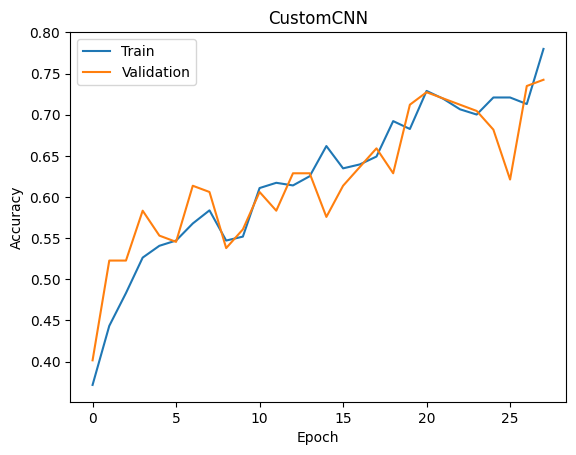

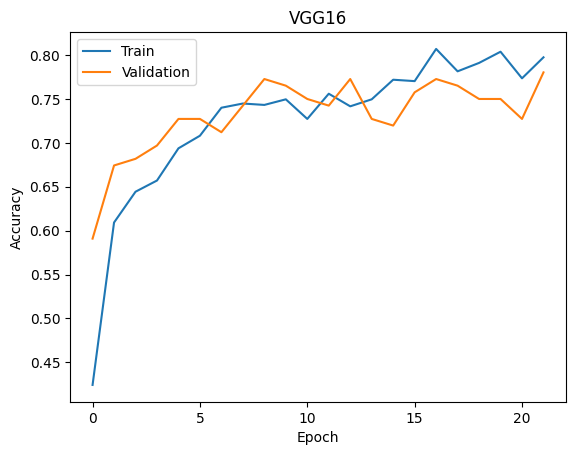

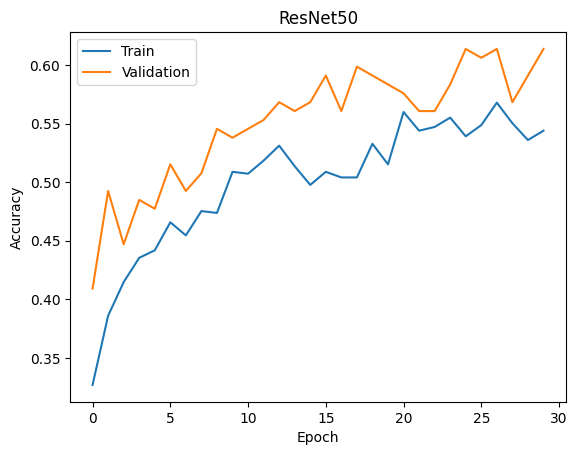

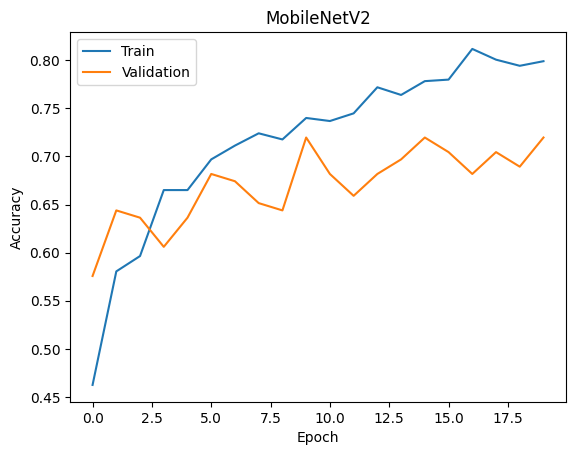

In [ ]:
def plot_history(history, title):
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    plt.show()

for name, history in histories.items():
    plot_history(history, name)


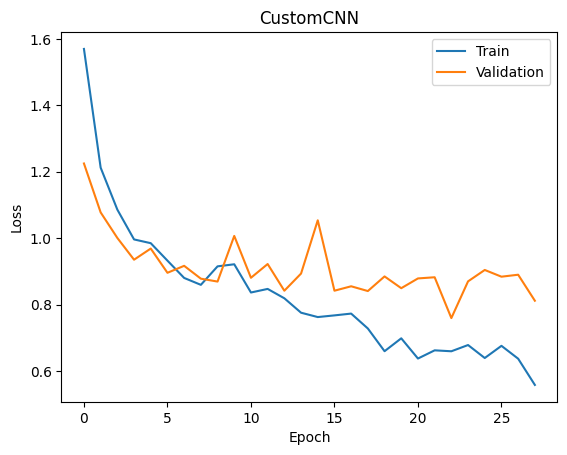

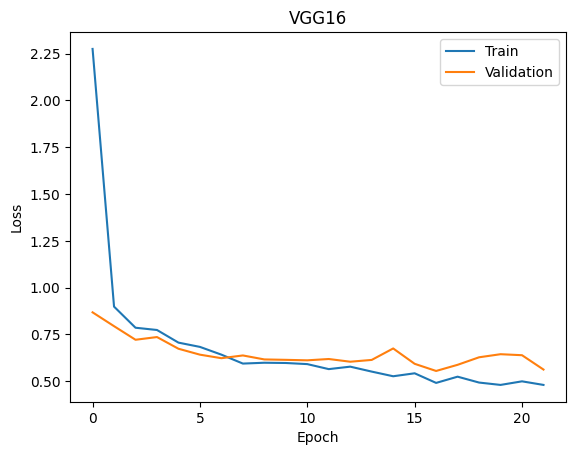

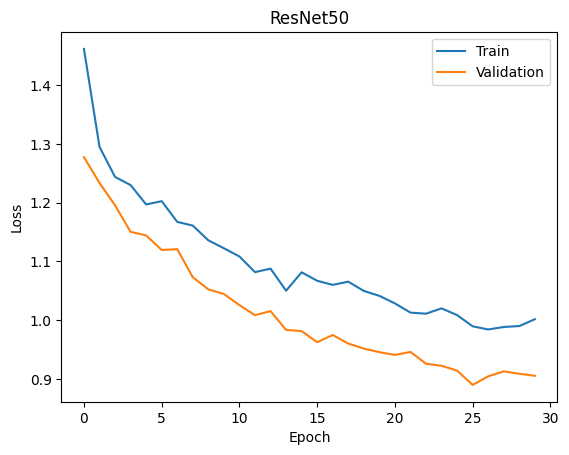

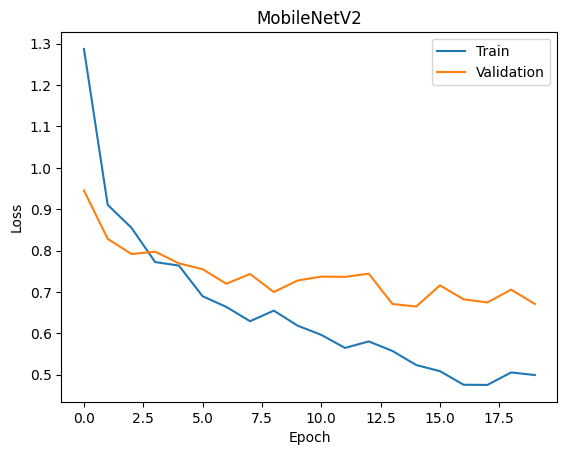

In [ ]:
def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    plt.show()

for name, history in histories.items():
    plot_loss(history, name)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


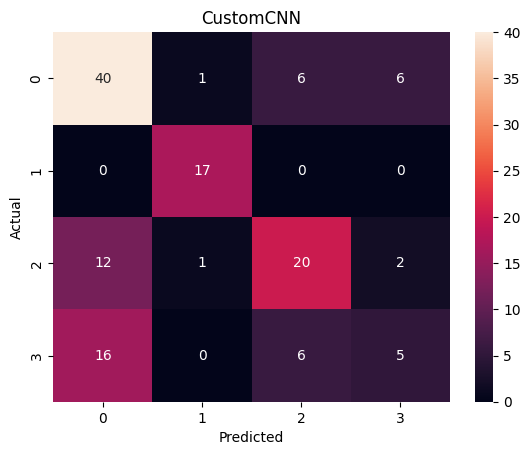

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


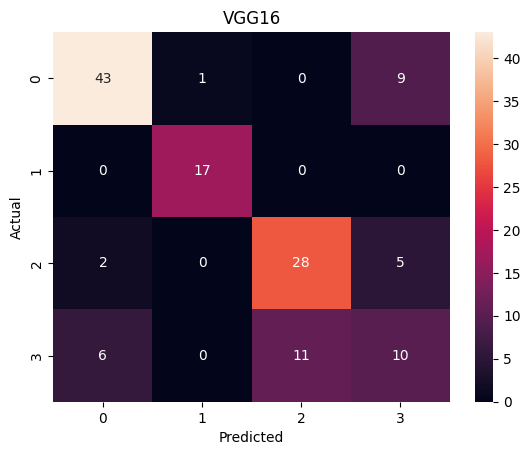

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


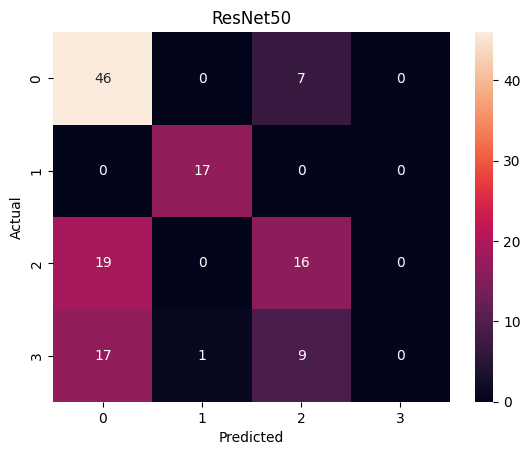

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


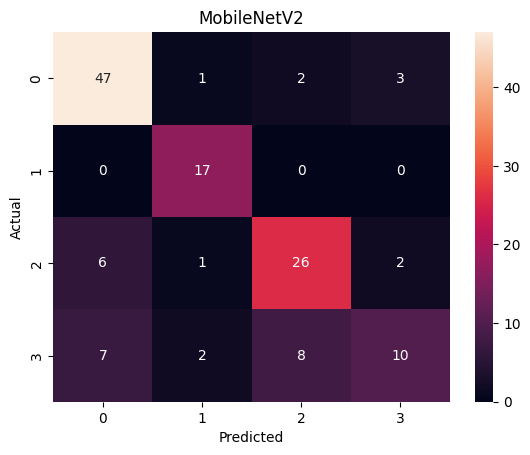

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion(model, title):
    preds = model.predict(test_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_data.classes

    cm = confusion_matrix(y_true, y_pred)

    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

for name, model in models_dict.items():
    plot_confusion(model, name)


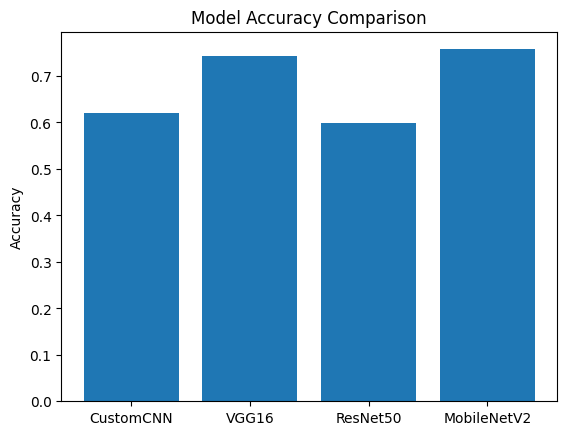

In [ ]:
plt.figure()
plt.bar(df_results["Model"], df_results["Accuracy"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


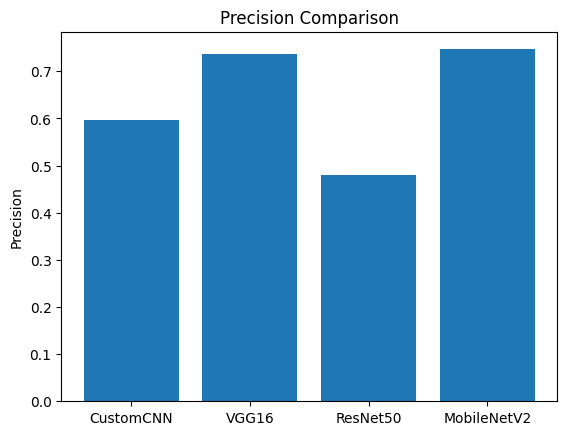

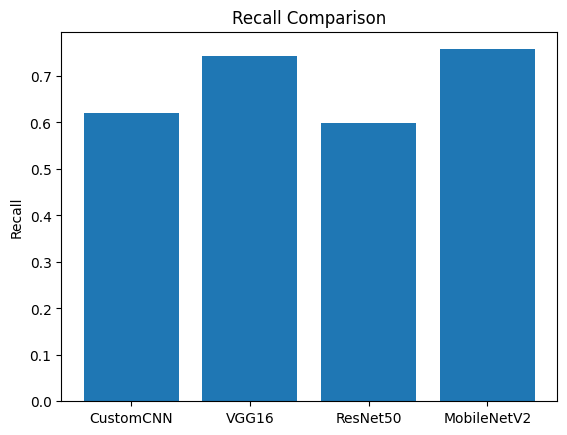

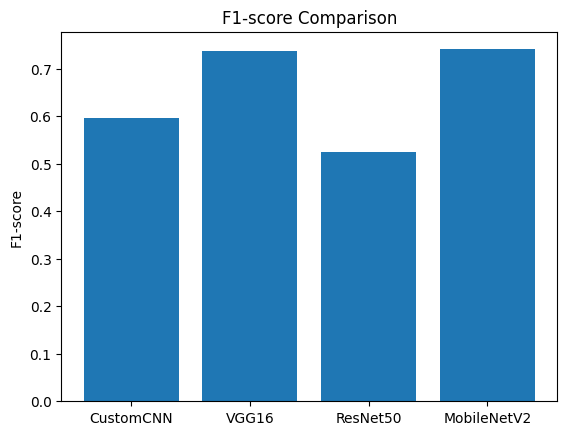

In [ ]:
metrics = ["Precision","Recall","F1-score"]

for metric in metrics:
    plt.figure()
    plt.bar(df_results["Model"], df_results[metric])
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step


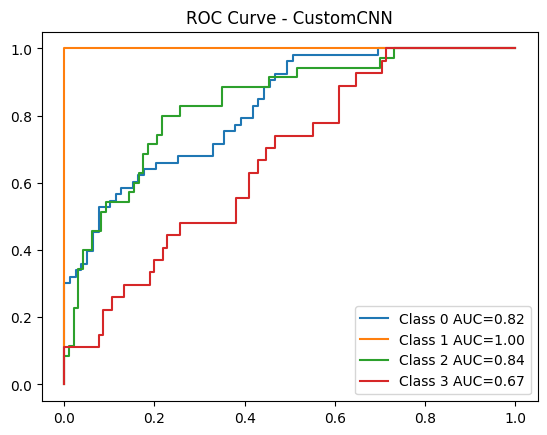

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


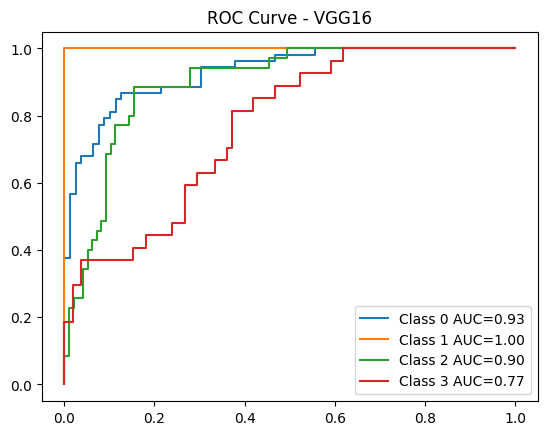

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


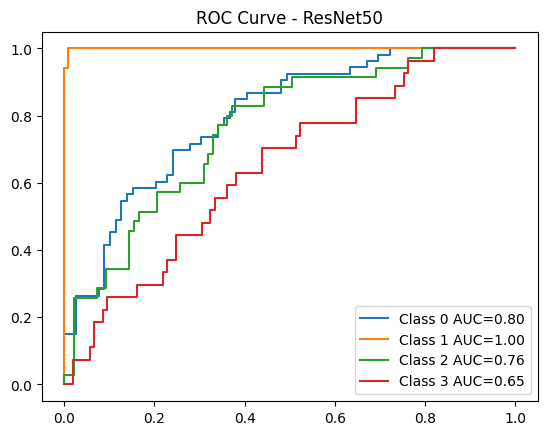

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


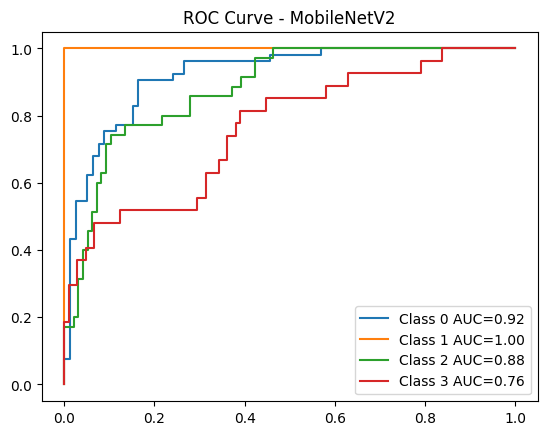

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

n_classes = 4
y_true = label_binarize(test_data.classes, classes=[0,1,2,3])

for name, model in models_dict.items():
    y_score = model.predict(test_data)

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} AUC={roc_auc:.2f}')

    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()
